In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy as hy
from pyclustering.cluster.kmedoids import kmedoids
%matplotlib inline

## Loading data

In [2]:
data = np.load("mds-population.npz")
print(data['D']) # Distance matrix
print(data['population_list']) # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


In [3]:
dist_matrix = data['D']
pop_list = [x.decode('UTF-8') for x in data['population_list']]

## (a)

### (i)

#### This is made on the assumption that the data lies in a 2D world, only two factors affect where the data point is. Which means the difference/distance between city A and city B are on the same dimension as city A and city C etc. We are losing more information with less dimension we have. There would be a problem is there are a lot of data points and the pairwise difference between them are all different, then we would need to have more dimensions to perserve more accurate pairwise information.

#### We could measure the loss by calculating the new pairwise distance between each of the cities and sum up the total difference of the new distance comparing with the original distance in the matrix.

In [4]:
mds_2 = MDS(2, dissimilarity= "precomputed", random_state = 88)
m_2_dim = mds_2.fit_transform(dist_matrix)
m_2_dim

array([[ 198.45506802,  284.20369164],
       [  83.9324846 ,  104.48856661],
       [ 133.40400187,  179.01420415],
       [ 174.72261239,  178.75938668],
       [  67.25105753,  136.7005667 ],
       [  11.34834598,   67.48030752],
       [ 218.66943003,  244.50764215],
       [ -63.48512067,   31.67117456],
       [ -70.36520461,   68.57702097],
       [ -25.18949089,   63.43114387],
       [ -14.12218478,  -37.13858982],
       [ -50.77361922,  -94.12472551],
       [ -37.39977473, -112.65810498],
       [ -31.02168071,  -78.2396997 ],
       [  77.42622261,  -49.54003   ],
       [  64.18473306, -125.11336303],
       [ -44.41775992,   24.80470562],
       [  -7.312192  ,  -23.91577619],
       [ -28.9322258 ,  -29.77666156],
       [  98.97255892,  -62.69094482],
       [ 123.60875692,  -25.53999807],
       [  76.10348348,  -90.76588845],
       [ -60.22207422,  -25.74035113],
       [  42.3372453 ,  -89.64676582],
       [ -40.05558367,  116.31269647],
       [ -37.98271475,   

### (ii)

In [5]:
# Function to calculate loss
def cal_loss(ori_matrix, new_matrix):
    n, m = new_matrix.shape
    total_loss = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_loss = total_loss + abs(np.linalg.norm(new_matrix[i] - new_matrix[j]) - ori_matrix[i, j])
    return total_loss

In [6]:
# Calculate the loss for n = 2 to 42
all_loss_list = []
for k in range(2, 21):
    mds_temp = MDS(k, dissimilarity= "precomputed", random_state = 88)
    m_temp_dim = mds_temp.fit_transform(dist_matrix)
    all_loss_list.append(cal_loss(dist_matrix, m_temp_dim))

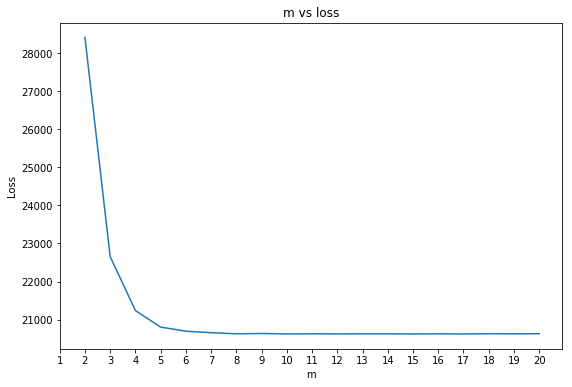

In [7]:
_ = plt.figure(figsize = (9, 6))
_ = plt.plot(np.arange(2, 21), all_loss_list)
_ = plt.xticks(np.arange(1, 21))
_ = plt.ylabel("Loss")
_ = plt.xlabel("m")
_ = plt.title("m vs loss")

#### 5 dimensions are necessary to capture most of the variation in the data. For that the decrease in loss flattens after m = 5

#### We found the multidimensional scaling of from m = 2 to 20, and calculated the individual pairwise distance between all the points. Then we compared and sum the absolute difference between the pairwise distance stored in the original distance matrix and the new distance we calculated. Then we plot this loss vs m and saw where the decrease of loss slowed down reletively and it was m = 5.

### (iii)

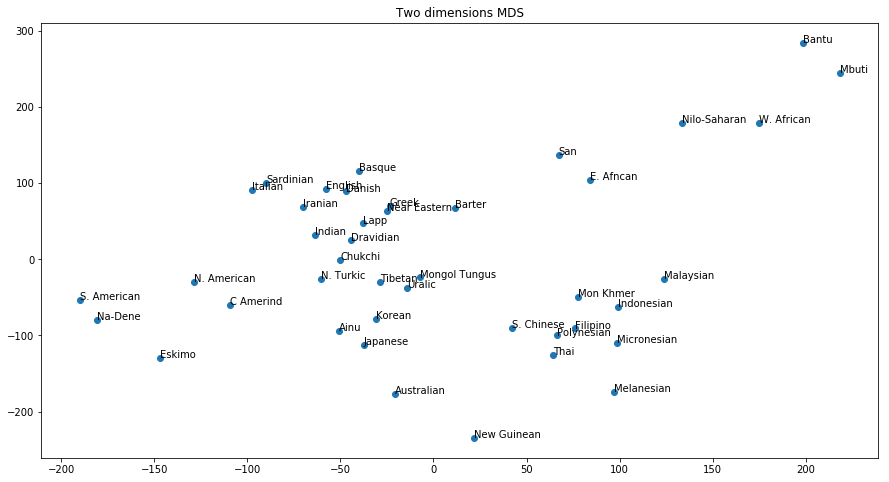

In [8]:
# Plotting
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
_ = ax.scatter(m_2_dim[:,0], m_2_dim[:,1])

# Labelling datapoint
for k, name in enumerate(pop_list):
    ax.annotate(name, (m_2_dim[k,0], m_2_dim[k,1]))
    
_ = plt.title("Two dimensions MDS")

## (b)

In [9]:
data_set = [[x,y] for x,y in list(zip(m_2_dim[:,0], m_2_dim[:,1]))]

In [10]:
# Running k-means and selecting best k with for loop
km_loss_list = []
n_param = np.arange(2, 31)

for k in n_param:
    km = KMeans(n_clusters = k, random_state = 88, n_jobs = -1)
    km.fit(data_set)
    km_loss_list.append(km.inertia_)

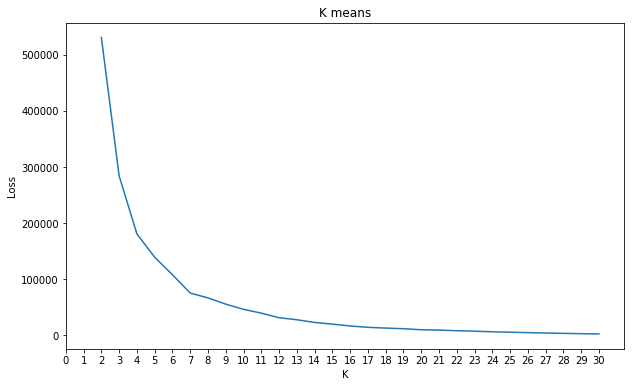

In [11]:
_ = plt.figure(figsize = (10, 6))
_ = plt.plot(n_param, km_loss_list)
_ = plt.xticks(np.arange(0, 31))
_ = plt.title("K means")
_ = plt.xlabel("K")
_ = plt.ylabel("Loss")

### Here we choose K = 7 using the elbow method. The loss seems to be decreasing rapidly until this point

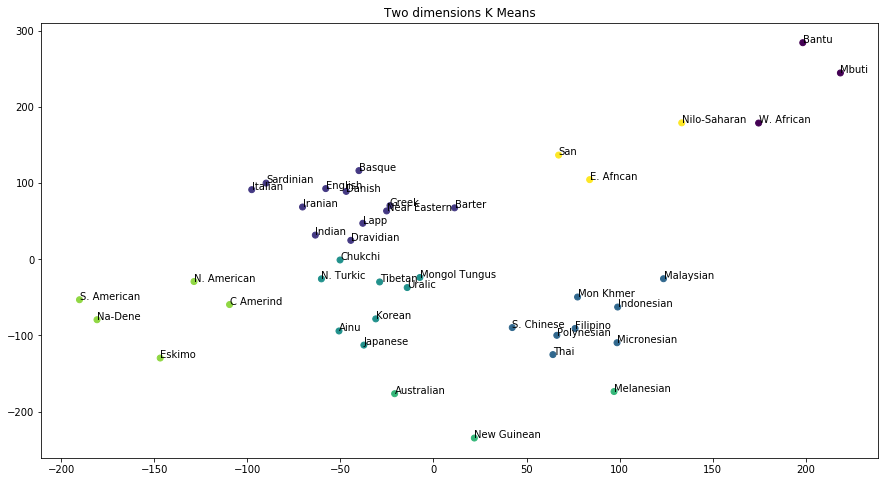

In [12]:
km = KMeans(n_clusters = 7, random_state = 88, n_jobs = -1)
km.fit(data_set)

# Plotting
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
_ = ax.scatter(m_2_dim[:,0], m_2_dim[:,1], c = km.labels_)

# Labelling datapoint
for k, name in enumerate(pop_list):
    ax.annotate(name, (m_2_dim[k,0], m_2_dim[k,1]))
    
_ = plt.title("Two dimensions K Means")

### It does look good on the two dimension plot we have here. However, we lost a lot of information on pairwise distance in multi-dimension. Thus, we do not agree with the result clustering in that sense.

## (C)

In [13]:
hier_result = hy.linkage(dist_matrix, method = "complete")

/Users/hangyulin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


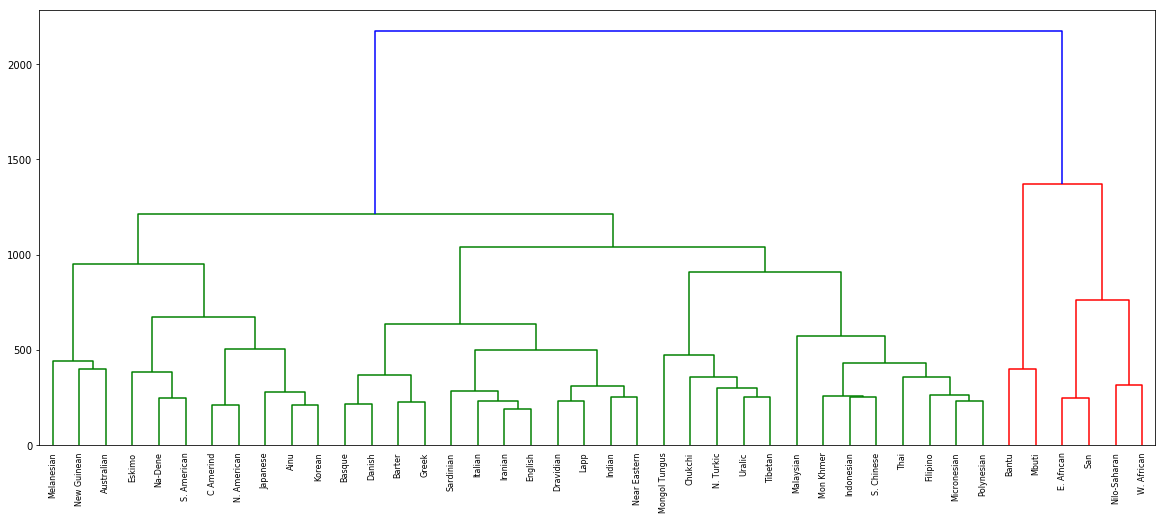

In [14]:
plt.figure(figsize = (20,8))
hier_dedm = hy.dendrogram(hier_result, labels = pop_list)

In [15]:
hier_350_labels = hy.fcluster(hier_result, 7, 'maxclust')

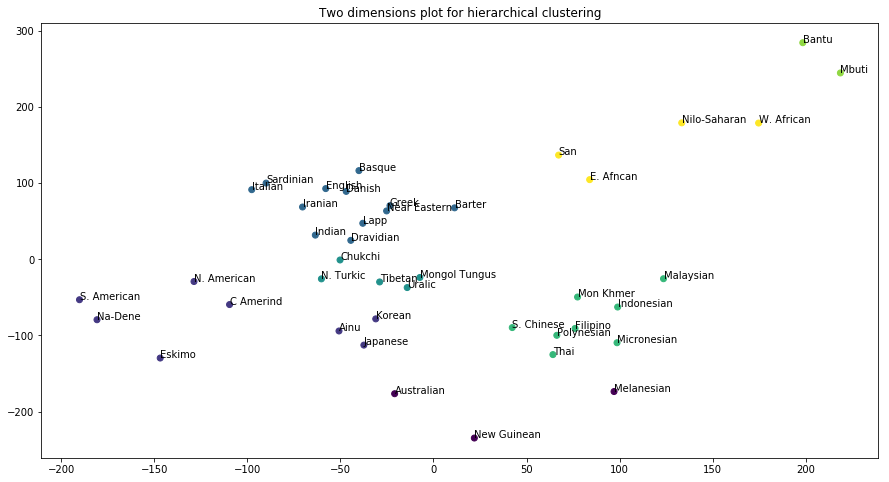

In [16]:
# Plotting
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
_ = ax.scatter(m_2_dim[:,0], m_2_dim[:,1], c = hier_350_labels)

# Labelling datapoint
for k, name in enumerate(pop_list):
    ax.annotate(name, (m_2_dim[k,0], m_2_dim[k,1]))
    
_ = plt.title("Two dimensions plot for hierarchical clustering")

### We used the complete hierarchical clustering with same number of clustering as k means. They seem to be the same except for a few points. Overall, k means seems to have clustered the datapoints better when looking at 2-D. But the complete hierarchical clustering had more information about pairwise distance, so it would be better.

## (d)

In [17]:
# Use k medoids from library
kmo = kmedoids(dist_matrix, np.random.randint(0, 42, 7))
kmo.process()
kmo_labels = kmo.get_clusters()

In [18]:
# Change format of the labels for plotting
kmo_c = []
for i in range(len(data_set)):
    for j in range(len(kmo_labels)):
        if i in kmo_labels[j]:
            kmo_c.append(j)

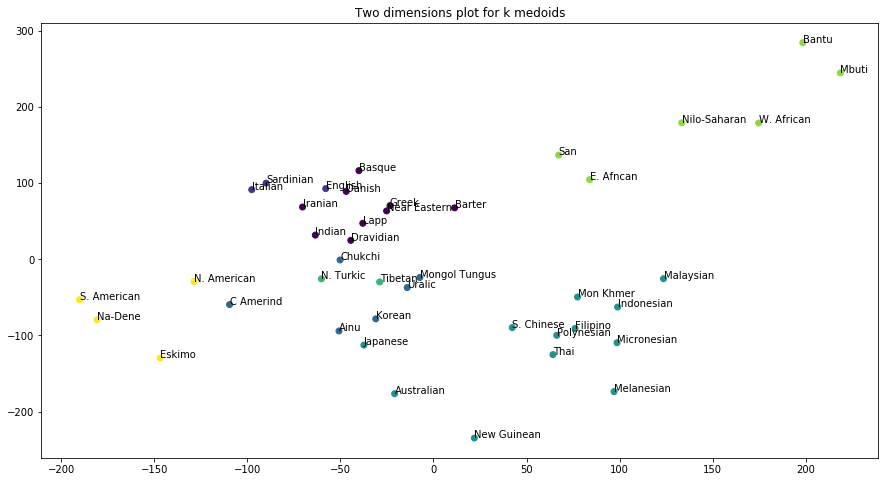

In [19]:
# Plotting
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
_ = ax.scatter(m_2_dim[:,0], m_2_dim[:,1], c = kmo_c)

# Labelling datapoint
for k, name in enumerate(pop_list):
    ax.annotate(name, (m_2_dim[k,0], m_2_dim[k,1]))
    
_ = plt.title("Two dimensions plot for k medoids")

### Results from k medoids seems not as good on the 2-D plotting. Maybe due to bad random selection of the initial medoids. There are some noticeable differences between k medoids and k means plot. The outcome all depends on the initial medoids.